<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/Fisher_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from astropy.cosmology import LambdaCDM, FlatLambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

In [2]:
cosmo1=FlatLambdaCDM(H0=70, Om0=0.3)
cosmo2=LambdaCDM(H0=70, Om0=0.3,Ode0=0.6)
cosmo1.is_equivalent(cosmo2)

False

Text(0, 0.5, '$D_A$ [Mpc]')

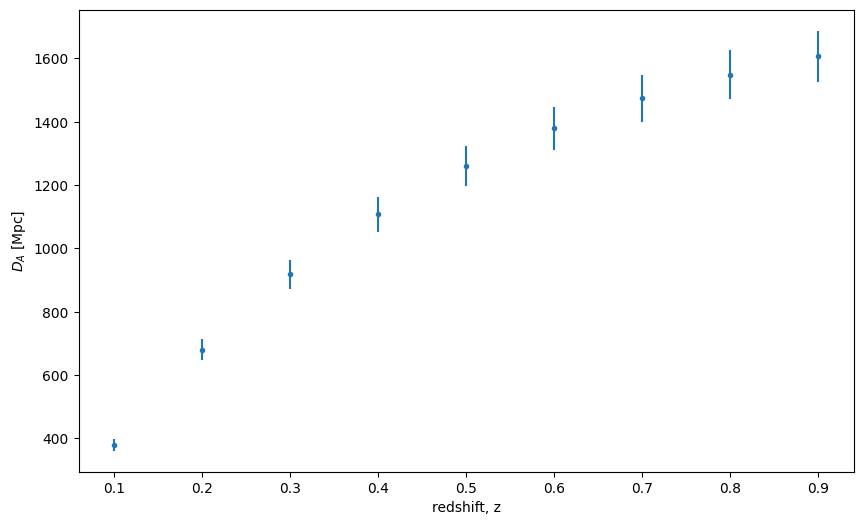

In [89]:
z=np.arange(0.1,1,0.1)
da_data=cosmo1.angular_diameter_distance(z).value
da_err=0.05*da_data

plt.errorbar(z,da_data,yerr=da_err,fmt='.')
plt.xlabel('redshift, z')
plt.ylabel(r'$D_A$ [Mpc]')

In [100]:
da_model=cosmo1.angular_diameter_distance(z).value
chi2=np.sum((da_data-da_model)**2/da_err**2)

Lets do a 1-D examination of $\Omega_m$ constraints from the $D_A$ data

Need to compute: $\frac{\partial^2\ell}{\partial\theta^2}$

In [101]:
dOm=0.01 # small delta change in parameter to compute numerical derivatives

cosmo_Om_p=FlatLambdaCDM(H0=70, Om0=0.3+dOm)
da_model_Om_p=cosmo_Om_p.angular_diameter_distance(z).value
chi2_Om_p=np.sum((da_data-da_model_Om_p)**2/da_err**2)

cosmo_Om_m=FlatLambdaCDM(H0=70, Om0=0.3-dOm)
da_model_Om_m=cosmo_Om_m.angular_diameter_distance(z).value
chi2_Om_m=np.sum((da_data-da_model_Om_m)**2/da_err**2)


Compute 2nd derivative using central finite difference formulae

In [102]:
dl2=(chi2_Om_p-2*chi2+chi2_Om_m)/dOm**2

display(Latex(r'\frac{\partial^2\ell}{\partial\Omega_M^2}='),dl2)

<IPython.core.display.Latex object>

969.1380141631845

In [103]:
display(Latex(r'\sigma_{\Omega_M}='),1/np.sqrt(dl2))

<IPython.core.display.Latex object>

0.03212234080751068

## Q. How does this improve if you have more observations of $D_A$? Try either more observations between 0<z<1 or over a larger redshift range.

Ok, lets go to the 2-D case and investigate $H_0$ and $\Omega_M$

In [9]:
dOm=0.01 # small delta change in parameter to compute numerical derivatives
dH=1

cosmo=FlatLambdaCDM(H0=70+dH, Om0=0.3+dOm)
da_model=cosmo.angular_diameter_distance(z).value
chi2_p_p=np.sum((da_data-da_model)**2/da_err**2)

cosmo=FlatLambdaCDM(H0=70-dH, Om0=0.3+dOm)
da_model=cosmo.angular_diameter_distance(z).value
chi2_m_p=np.sum((da_data-da_model)**2/da_err**2)

cosmo=FlatLambdaCDM(H0=70+dH, Om0=0.3-dOm)
da_model=cosmo.angular_diameter_distance(z).value
chi2_p_m=np.sum((da_data-da_model)**2/da_err**2)

cosmo=FlatLambdaCDM(H0=70-dH, Om0=0.3-dOm)
da_model=cosmo.angular_diameter_distance(z).value
chi2_m_m=np.sum((da_data-da_model)**2/da_err**2)

dl2_dOmdH = (chi2_m_m+ chi2_p_p- chi2_p_m - chi2_m_p)/(4*dOm*dH)
display(Latex(r'\frac{\partial^2\ell}{\partial\Omega_M\partial H_0}='),dl2_dOmdH)

<IPython.core.display.Latex object>

34.22928688057407

In [10]:
cosmo=FlatLambdaCDM(H0=70, Om0=0.3)
da_model=cosmo.angular_diameter_distance(z).value
chi2_0=np.sum((da_data-da_model)**2/da_err**2)

cosmo=FlatLambdaCDM(H0=70+dH, Om0=0.3)
da_model=cosmo.angular_diameter_distance(z).value
chi2_p=np.sum((da_data-da_model)**2/da_err**2)

cosmo=FlatLambdaCDM(H0=70-dH, Om0=0.3)
da_model=cosmo.angular_diameter_distance(z).value
chi2_m=np.sum((da_data-da_model)**2/da_err**2)

dl2_dH2=(chi2_p-2*chi2_0+chi2_m)/dH**2
display(Latex(r'\frac{\partial^2\ell}{\partial H_0^2}='),dl2_dH2)

<IPython.core.display.Latex object>

1.4702876863406182

Construct the Fisher Matrix and the covariance matrix

In [120]:
A=np.zeros((2,2))

A[0,0] = 0.5*dl2
A[1,1] = 0.5*dl2_dH2
A[1,0] = A[0,1] = 0.5*dl2_dOmdH

cov=np.linalg.pinv(A)

print(A)

print(cov)

[[484.56900708  17.11464344]
 [ 17.11464344   0.73514384]]
[[ 0.01161055 -0.27030134]
 [-0.27030134  7.65307511]]


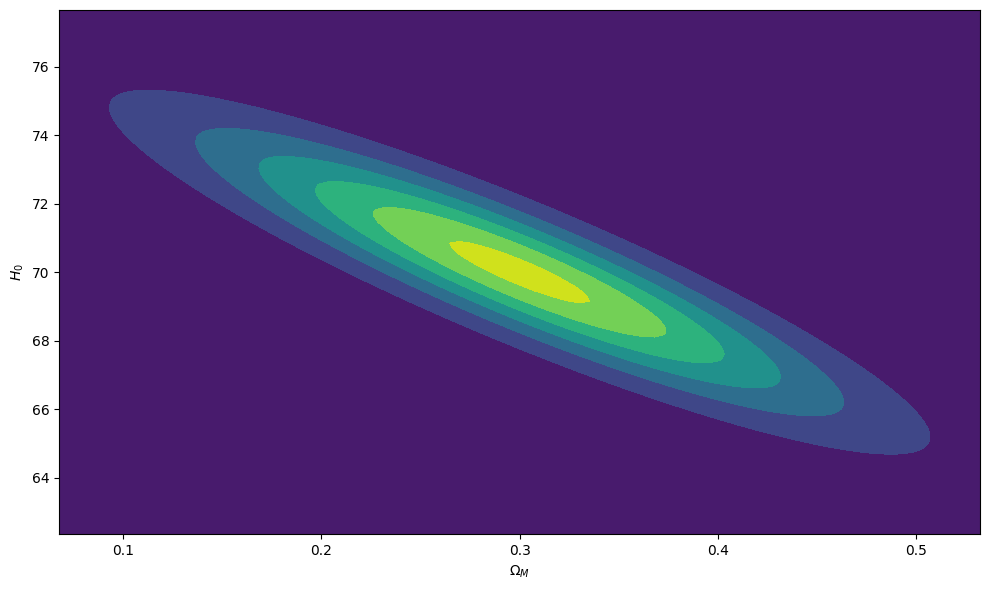

In [121]:
from scipy.stats import multivariate_normal

fig = plt.figure()
# Setting mean of the distribution
mean = np.array([0.3,70.])

# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov, mean = mean,)

# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = mean[0], mean[1]
sigma_1, sigma_2 = cov[0,0], cov[1,1]

x = np.linspace(mean_1-20*sigma_1, mean_1+20*sigma_1, num=100)
y = np.linspace(mean_2-1*sigma_2, mean_2+1*sigma_2, num=100)
X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

plt.contourf(X, Y, pdf,)
plt.xlabel(r"$\Omega_M$")
plt.ylabel(r"$H_0$")
plt.tight_layout()
plt.show()